# 2D Plane Strain FEA — scikit-fem (Full Spring)

2D finite element analysis of the **complete doubly-clamped bistable spring**
using `scikit-fem`.

**Geometry**: Two parallel CCS half-beam pairs + rigid shuttle, merged into
a single polygon via Shapely boolean union.

**Boundary conditions**:
- Left anchor (x≈0): clamped, u_x = u_y = 0
- Right anchor (x≈anchor_distance): clamped, u_x = u_y = 0
- Shuttle (center): prescribe u_y, u_x free (axial constraint comes from
  doubly-clamped geometry + shuttle material stiffness)

**Expected result**: Positive force region followed by snap-through — unlike
the single half-beam (notebook 2a) which shows only monotonic negative force.

Runs at 3 mesh densities (10%, 50%, 100%) for convergence study.

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

import triangle as tr
import skfem
from skfem import *
from skfem.models.elasticity import linear_elasticity, lame_parameters
from skfem.helpers import dot, ddot, sym_grad, transpose, eye, grad, det, inv
from skfem.assembly import BilinearForm, LinearForm

sys.path.insert(0, os.path.dirname(os.path.abspath("__file__")))
from full_spring_utils import (
    POLY_SI, DEFAULT_FULL_SPRING_PARAMS,
    get_full_spring_polygon, identify_bc_nodes_2d,
)

print(f"scikit-fem version: {skfem.__version__}")

# Parameters
P = DEFAULT_FULL_SPRING_PARAMS
anchor_dist = P['anchor_distance']
half_span = P['half_span']
shuttle_len = P['shuttle_length']
h = P['initial_offset']
t = POLY_SI['t']
E = POLY_SI['E']
nu = POLY_SI['nu']
lam, mu = lame_parameters(E, nu)

print(f"Full spring: anchor_dist={anchor_dist} µm, half_span={half_span} µm")
print(f"  h={h} µm, t={t} µm, Q={h/t:.2f}")
print(f"Lamé: λ={lam:.1f}, μ={mu:.1f} MPa")

os.makedirs('plots', exist_ok=True)
os.makedirs('results', exist_ok=True)

scikit-fem version: 12.0.1
Full spring: anchor_dist=80.0 µm, half_span=36.5 µm
  h=1.2 µm, t=0.5 µm, Q=2.40
Lamé: λ=51522.2, μ=65573.8 MPa


## 1. Full Spring Polygon

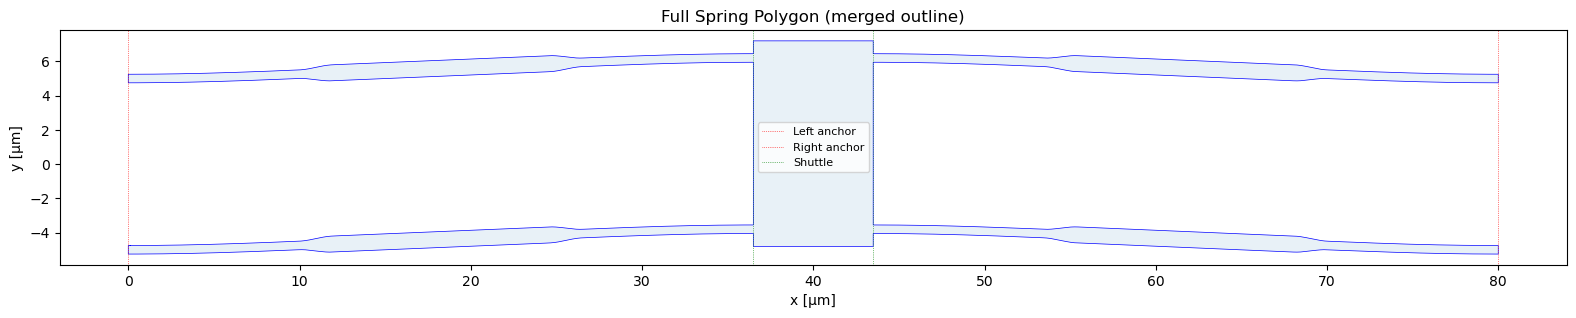

Polygon: 4805 vertices


In [2]:
# Generate merged polygon
poly = get_full_spring_polygon(n_points=600)

fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(poly[:, 0], poly[:, 1], 'b-', linewidth=0.5)
ax.fill(poly[:, 0], poly[:, 1], alpha=0.1)
ax.set_aspect('equal')
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')
ax.set_title('Full Spring Polygon (merged outline)')
ax.axvline(0, color='r', ls=':', lw=0.5, label='Left anchor')
ax.axvline(anchor_dist, color='r', ls=':', lw=0.5, label='Right anchor')
ax.axvline(half_span, color='g', ls=':', lw=0.5, label='Shuttle')
ax.axvline(half_span + shuttle_len, color='g', ls=':', lw=0.5)
ax.legend(fontsize=8)
fig.tight_layout()
plt.show()
print(f"Polygon: {len(poly)} vertices")

## 2. Nonlinear Forms (Total Lagrangian)

Defined once, reused across all mesh densities.

In [3]:
I2 = np.eye(2).reshape(2, 2, 1, 1)

def mat(A, B):
    """Matrix-matrix product for (2,2,...) tensor fields."""
    return np.einsum('ij...,jk...->ik...', A, B)

@BilinearForm
def stiffness_nl(u, v, w):
    """Tangent stiffness for Total Lagrangian with St. Venant-Kirchhoff material."""
    du = grad(w['prev'])
    F = I2 + du
    GL = 0.5 * (mat(transpose(F), F) - I2)
    trE = GL[0, 0] + GL[1, 1]
    S = lam * trE * I2 + 2.0 * mu * GL

    dv = grad(v)
    dw = grad(u)

    dGL = 0.5 * (mat(transpose(F), dw) + mat(transpose(dw), F))
    trDE = dGL[0, 0] + dGL[1, 1]
    dS = lam * trDE * I2 + 2.0 * mu * dGL
    dGL_v = 0.5 * (mat(transpose(F), dv) + mat(transpose(dv), F))

    k_mat = ddot(dS, dGL_v)
    k_geo = ddot(S, 0.5 * (mat(transpose(dw), dv) + mat(transpose(dv), dw)))
    return k_mat + k_geo


@LinearForm
def internal_forces(v, w):
    """Internal force vector (residual) for Total Lagrangian."""
    du = grad(w['prev'])
    F = I2 + du
    GL = 0.5 * (mat(transpose(F), F) - I2)
    trE = GL[0, 0] + GL[1, 1]
    S = lam * trE * I2 + 2.0 * mu * GL
    dv = grad(v)
    dGL_v = 0.5 * (mat(transpose(F), dv) + mat(transpose(dv), F))
    return ddot(S, dGL_v)

print("Nonlinear forms defined.")

Nonlinear forms defined.


## 3. Mesh Density Sweep

Three density levels:
- **10%** (coarse): quick validation (~1-2 min)
- **50%** (medium): convergence check
- **100%** (fine): production results

In [4]:
# Mesh density settings
# base_max_area is calibrated so that 100% gives similar per-beam density to notebook 2a
base_max_area = 0.008  # µm² at 100%

densities = {
    '10pct': {'scale': 10.0, 'n_nl_steps': 100, 'label': '10% density'},
    '50pct': {'scale': 2.0,  'n_nl_steps': 150, 'label': '50% density'},
    '100pct': {'scale': 1.0, 'n_nl_steps': 200, 'label': '100% density'},
}

# Store results for each density
all_results = {}

In [5]:
# Remove closing point for triangle mesher
poly_open = poly.copy()
if np.allclose(poly_open[0], poly_open[-1]):
    poly_open = poly_open[:-1]

n_verts = len(poly_open)
segments = np.column_stack([np.arange(n_verts), (np.arange(n_verts) + 1) % n_verts])
tri_input = {'vertices': poly_open, 'segments': segments}

print(f"Polygon vertices for meshing: {n_verts}")

Polygon vertices for meshing: 4804


In [ ]:
max_newton = 50
nl_tol = 1e-8

for density_name, density_cfg in densities.items():
    print(f"\n{'='*60}")
    print(f"Density: {density_cfg['label']} (scale={density_cfg['scale']})")
    print(f"{'='*60}")
    
    # --- Mesh ---
    max_area = base_max_area * density_cfg['scale']
    tri_out = tr.triangulate(tri_input, f'pq30a{max_area}')
    nodes = tri_out['vertices']
    elems = tri_out['triangles']
    print(f"Mesh: {len(nodes)} nodes, {len(elems)} triangles (max_area={max_area:.4f})")
    
    # --- scikit-fem mesh ---
    mesh = MeshTri(
        np.ascontiguousarray(nodes.T, dtype=np.float64),
        np.ascontiguousarray(elems.T, dtype=np.int64),
    )
    
    # --- Basis ---
    elem = ElementTriP1()
    ib = Basis(mesh, ElementVector(elem))
    N = mesh.nvertices
    ndofs = 2 * N
    print(f"System DOFs: {ndofs}")
    
    # --- Boundary nodes ---
    bc = identify_bc_nodes_2d(nodes, anchor_dist, half_span, shuttle_len)
    print(f"Left anchor: {len(bc['left_anchor'])} nodes")
    print(f"Right anchor: {len(bc['right_anchor'])} nodes")
    print(f"Shuttle: {len(bc['shuttle'])} nodes")
    
    # DOFs: interleaved [x0,y0,x1,y1,...]
    left_x = 2 * bc['left_anchor']
    left_y = 2 * bc['left_anchor'] + 1
    right_x = 2 * bc['right_anchor']
    right_y = 2 * bc['right_anchor'] + 1
    fixed_dofs = np.concatenate([left_x, left_y, right_x, right_y])
    
    shuttle_y_dofs = 2 * bc['shuttle'] + 1
    all_bc = np.concatenate([fixed_dofs, shuttle_y_dofs])
    
    # --- Nonlinear sweep ---
    n_steps = density_cfg['n_nl_steps']
    delta_vals = np.linspace(0, -2*h, n_steps)
    F_nl = np.zeros(n_steps)
    
    u_current = np.zeros(ndofs)
    
    for i, delta in enumerate(delta_vals):
        u_target = u_current.copy()
        u_target[fixed_dofs] = 0.0
        u_target[shuttle_y_dofs] = delta
        
        u_iter = u_target.copy()
        converged = False
        
        for nit in range(max_newton):
            u_field = ib.interpolate(u_iter)
            Kt = stiffness_nl.assemble(ib, prev=u_field)
            fint = internal_forces.assemble(ib, prev=u_field)
            
            residual = fint.copy()
            residual[all_bc] = 0.0
            res_norm = np.linalg.norm(residual)
            
            if res_norm < nl_tol:
                converged = True
                break
            
            du_corr = solve(*condense(Kt, -residual, D=all_bc))
            u_iter += du_corr
        
        if not converged and i > 0:
            print(f"  Step {i}: δ={delta:.4f}, not converged (res={res_norm:.2e})")
        
        u_current = u_iter.copy()
        
        u_field = ib.interpolate(u_current)
        fint = internal_forces.assemble(ib, prev=u_field)
        F_nl[i] = np.sum(fint[shuttle_y_dofs])
        
        if i % 50 == 0:
            print(f"  Step {i}/{n_steps}: δ={delta:.3f} µm, F={F_nl[i]:.4f} µN")
    
    print(f"Done. F range: [{F_nl.min():.4f}, {F_nl.max():.4f}] µN")
    
    # Store results
    all_results[density_name] = {
        'delta': -delta_vals,
        'F': F_nl,
        'n_nodes': len(nodes),
        'n_elems': len(elems),
        'mesh': mesh,
        'u_final': u_current,
        'ib': ib,
    }
    
    # Save CSV
    np.savetxt(f'results/skfem_2d_full_{density_name}.csv',
               np.column_stack([-delta_vals, F_nl]),
               delimiter=',', header='delta_um,F_uN', comments='')
    print(f"Saved: results/skfem_2d_full_{density_name}.csv")


Density: 10% density (scale=10.0)
Mesh: 13397 nodes, 21883 triangles (max_area=0.0800)
System DOFs: 26794
Left anchor: 14 nodes
Right anchor: 14 nodes
Shuttle: 917 nodes
  Step 0/100: δ=0.000 µm, F=0.0000 µN
  Step 50/100: δ=-1.212 µm, F=-2.0859 µN
Done. F range: [-5.1785, 0.0376] µN
Saved: results/skfem_2d_full_10pct.csv

Density: 50% density (scale=2.0)
Mesh: 17481 nodes, 29919 triangles (max_area=0.0160)
System DOFs: 34962
Left anchor: 14 nodes
Right anchor: 14 nodes
Shuttle: 4301 nodes
  Step 0/150: δ=0.000 µm, F=0.0000 µN
  Step 50/150: δ=-0.805 µm, F=-4.3368 µN
  Step 100/150: δ=-1.611 µm, F=-0.1413 µN
Done. F range: [-5.1638, 0.0403] µN
Saved: results/skfem_2d_full_50pct.csv

Density: 100% density (scale=1.0)
Mesh: 24119 nodes, 43125 triangles (max_area=0.0080)
System DOFs: 48238
Left anchor: 14 nodes
Right anchor: 14 nodes
Shuttle: 8509 nodes
  Step 0/200: δ=0.000 µm, F=0.0000 µN
  Step 50/200: δ=-0.603 µm, F=-4.7105 µN
  Step 100/200: δ=-1.206 µm, F=-2.0798 µN


## 4. Mesh Convergence Plot

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

colors = {'10pct': 'green', '50pct': 'blue', '100pct': 'red'}
for name, res in all_results.items():
    label = f"{densities[name]['label']} ({res['n_nodes']} nodes, {res['n_elems']} elems)"
    ax.plot(res['delta'], res['F'], color=colors[name], linewidth=1.5, label=label)

# Overlay analytical for reference
try:
    ana = np.loadtxt('results/analytical_force_displacement.csv',
                     delimiter=',', skiprows=1)
    # Scale by 4 for full spring (4 half-beams)
    ax.plot(ana[:, 0], 4 * ana[:, 2], 'k:', linewidth=1.5,
            label='Analytical CCS (×4)')
except FileNotFoundError:
    pass

ax.axhline(0, color='gray', linewidth=0.5)
ax.set_xlabel('Shuttle displacement from initial [µm]')
ax.set_ylabel('Force F [µN]')
ax.set_title('scikit-fem 2D Full Spring — Mesh Convergence')
ax.legend()
ax.grid(True, alpha=0.3)

fig.tight_layout()
fig.savefig('plots/skfem_2d_full_convergence.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Deformed Shapes (Fine Mesh)

In [ ]:
# Use finest available mesh for deformed shape visualization
finest = '100pct' if '100pct' in all_results else list(all_results.keys())[-1]
res = all_results[finest]
mesh_vis = res['mesh']
ib_vis = res['ib']
ndofs_vis = 2 * mesh_vis.nvertices
bc_vis = identify_bc_nodes_2d(
    mesh_vis.p.T, anchor_dist, half_span, shuttle_len
)

left_x_v = 2 * bc_vis['left_anchor']
left_y_v = 2 * bc_vis['left_anchor'] + 1
right_x_v = 2 * bc_vis['right_anchor']
right_y_v = 2 * bc_vis['right_anchor'] + 1
fixed_v = np.concatenate([left_x_v, left_y_v, right_x_v, right_y_v])
shuttle_y_v = 2 * bc_vis['shuttle'] + 1
all_bc_v = np.concatenate([fixed_v, shuttle_y_v])

key_deltas = [0.0, -h/2, -h, -1.5*h, -2*h]
key_labels = ['δ=0', f'δ={h/2:.1f}', f'δ={h:.1f}', f'δ={1.5*h:.1f}', f'δ={2*h:.1f}']

fig, ax = plt.subplots(figsize=(16, 6))
ax.triplot(mesh_vis.p[0], mesh_vis.p[1], mesh_vis.t.T, 'k-', alpha=0.1, linewidth=0.2)

cmap_colors = plt.cm.viridis(np.linspace(0, 1, len(key_deltas)))

for k, (delta, label) in enumerate(zip(key_deltas, key_labels)):
    u_vis = np.zeros(ndofs_vis)
    u_vis[shuttle_y_v] = delta
    
    for _ in range(max_newton):
        u_field = ib_vis.interpolate(u_vis)
        Kt = stiffness_nl.assemble(ib_vis, prev=u_field)
        fint = internal_forces.assemble(ib_vis, prev=u_field)
        residual = fint.copy()
        residual[all_bc_v] = 0.0
        if np.linalg.norm(residual) < nl_tol:
            break
        du_c = solve(*condense(Kt, -residual, D=all_bc_v))
        u_vis += du_c
    
    ux = u_vis[0::2]
    uy = u_vis[1::2]
    ax.triplot(mesh_vis.p[0] + ux, mesh_vis.p[1] + uy, mesh_vis.t.T,
               '-', color=cmap_colors[k], linewidth=0.4, label=label)

ax.set_aspect('equal')
ax.set_xlabel('x [µm]')
ax.set_ylabel('y [µm]')
ax.set_title(f'Deformed Full Spring Shapes (2D, {finest})')
ax.legend(fontsize=9)

fig.tight_layout()
fig.savefig('plots/skfem_2d_full_deformed.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Force-Displacement Summary

In [ ]:
print(f"{'Density':15s} {'Nodes':>8s} {'Elems':>8s} {'F_max [µN]':>12s} {'F_min [µN]':>12s}")
print('-' * 60)
for name, res in all_results.items():
    print(f"{densities[name]['label']:15s} {res['n_nodes']:8d} {res['n_elems']:8d} "
          f"{res['F'].max():12.4f} {res['F'].min():12.4f}")

print(f"\nExpected: F_push ≈ 10 µN (4 × 2.48 analytical CCS half-beam)")
print(f"Expected: snap-through at δ ≈ {h:.1f} µm")